In [1]:
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, PoissonRegressor
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
import sklearn.preprocessing as preprocessing 

import regressionUtils as rg
import plotUtils as pu


In [2]:
county_df = pd.read_pickle("../Data/county_data_totals.pkl")
county_df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 3087 entries, 1001.0 to 56045.0
Data columns (total 65 columns):
 #   Column                                                                                  Non-Null Count  Dtype  
---  ------                                                                                  --------------  -----  
 0   Population estimates, July 1, 2019,  (V2019)                                            3087 non-null   float64
 1   Population estimates base, April 1, 2010,  (V2019)                                      3087 non-null   float64
 2   Population, percent change - April 1, 2010 (estimates base) to July 1, 2019,  (V2019)   3087 non-null   float64
 3   Population, Census, April 1, 2010                                                       3087 non-null   float64
 4   Persons under 5 years, percent                                                          3086 non-null   float64
 5   Persons under 18 years, percent                            

In [3]:
county_df.drop(county_df[county_df['deaths'] == 0].index, inplace = True) 
county_df['Deaths per 100k'] = 1e5*county_df['deaths']/county_df['Population estimates, July 1, 2019,  (V2019)']
pt_boxcox = preprocessing.PowerTransformer(method='box-cox', standardize=True)
county_df['Deaths per 100k, trans'] = pt_boxcox.fit_transform(county_df[['Deaths per 100k']])
# county_df['Deaths per 100k, trans'] = county_df['Deaths per 100k'] # comment this in instead of the above to not do the box cox transform (for plots showing it's use)

In [4]:
# pt_boxcox.inverse_transform(np.array(0.6).reshape(1, -1))

In [5]:
county_df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 3007 entries, 1001.0 to 56045.0
Data columns (total 67 columns):
 #   Column                                                                                  Non-Null Count  Dtype  
---  ------                                                                                  --------------  -----  
 0   Population estimates, July 1, 2019,  (V2019)                                            3007 non-null   float64
 1   Population estimates base, April 1, 2010,  (V2019)                                      3007 non-null   float64
 2   Population, percent change - April 1, 2010 (estimates base) to July 1, 2019,  (V2019)   3007 non-null   float64
 3   Population, Census, April 1, 2010                                                       3007 non-null   float64
 4   Persons under 5 years, percent                                                          3007 non-null   float64
 5   Persons under 18 years, percent                            

In [6]:
# main_features_df = county_df[["Black or African American alone, percent(a)", "Bachelor's degree or higher, percent of persons age 25 years+, 2015-2019", \
#                               "Persons  without health insurance, under age 65 years, percent", "Households with a broadband Internet subscription, percent, 2015-2019", \
#                               "Median value of owner-occupied housing units, 2015-2019", \
#                               "Deaths per 100k, trans"]].dropna()

main_features_df = county_df[[\
#                             no    "Persons under 5 years, percent",\
                                "Persons 65 years and over, percent",\
#                             no    "White alone, percent",\
                                "Black or African American alone, percent(a)",\
#                             no    "Asian alone, percent(a)",\
                                "Two or More Races, percent",\
                                "White alone, not Hispanic or Latino, percent",\
                                "Median value of owner-occupied housing units, 2015-2019",\
#                             no    "Median gross rent, 2015-2019",\
                                "Living in same house 1 year ago, percent of persons age 1 year+, 2015-2019",\
                                "Households with a computer, percent, 2015-2019",\
                                "Households with a broadband Internet subscription, percent, 2015-2019",
                                "High school graduate or higher, percent of persons age 25 years+, 2015-2019",\
                                "Bachelor's degree or higher, percent of persons age 25 years+, 2015-2019",\
                                "Persons  without health insurance, under age 65 years, percent",\
                                "Median household income (in 2019 dollars), 2015-2019",\
                                "Deaths per 100k, trans"]].dropna()


main_features_df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 3004 entries, 1001.0 to 56045.0
Data columns (total 13 columns):
 #   Column                                                                       Non-Null Count  Dtype  
---  ------                                                                       --------------  -----  
 0   Persons 65 years and over, percent                                           3004 non-null   float64
 1   Black or African American alone, percent(a)                                  3004 non-null   float64
 2   Two or More Races, percent                                                   3004 non-null   float64
 3   White alone, not Hispanic or Latino, percent                                 3004 non-null   float64
 4   Median value of owner-occupied housing units, 2015-2019                      3004 non-null   float64
 5   Living in same house 1 year ago, percent of persons age 1 year+, 2015-2019   3004 non-null   float64
 6   Households with a computer, pe

In [7]:
# drop some outliers
main_features_df.drop(main_features_df[main_features_df['Two or More Races, percent'] > 20].index, inplace = True) 
main_features_df.drop(main_features_df[main_features_df['Living in same house 1 year ago, percent of persons age 1 year+, 2015-2019'] < 70].index, inplace = True) 
# no main_features_df.drop(main_features_df[main_features_df['High school graduate or higher, percent of persons age 25 years+, 2015-2019'] < 50].index, inplace = True) 
# no main_features_df.drop(main_features_df[main_features_df['Median value of owner-occupied housing units, 2015-2019'] > 0.8e6].index, inplace = True) 
main_features_df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 2988 entries, 1001.0 to 56045.0
Data columns (total 13 columns):
 #   Column                                                                       Non-Null Count  Dtype  
---  ------                                                                       --------------  -----  
 0   Persons 65 years and over, percent                                           2988 non-null   float64
 1   Black or African American alone, percent(a)                                  2988 non-null   float64
 2   Two or More Races, percent                                                   2988 non-null   float64
 3   White alone, not Hispanic or Latino, percent                                 2988 non-null   float64
 4   Median value of owner-occupied housing units, 2015-2019                      2988 non-null   float64
 5   Living in same house 1 year ago, percent of persons age 1 year+, 2015-2019   2988 non-null   float64
 6   Households with a computer, pe

In [8]:
#sns.heatmap(main_features_df.corr(), cmap="seismic", vmin=-1, vmax=1);

In [9]:
# pp = sns.pairplot(main_features_df, plot_kws=dict(alpha=.1, edgecolor='none'))
# for ax in pp.axes.flatten():
#     ax.set_xlabel(ax.get_xlabel(), rotation = 5)
#     ax.set_ylabel(ax.get_ylabel(), rotation = 85)
##     ax.yaxis.get_label().set_horizontalalignment('right')    

In [10]:
X, y = main_features_df.drop('Deaths per 100k, trans',axis=1), main_features_df['Deaths per 100k, trans']
input_features = list(X.columns)

X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=110) #hold out 20% of the data for final testing

#this helps with the way kf will generate indices below
X, y = np.array(X), np.array(y)
X_test, y_test = np.array(X_test), np.array(y_test)

Simple regression scores:  [0.241, 0.268, 0.238, 0.289, 0.267] 

Simple mean cv r^2: 0.261 +- 0.019 

r2:  0.2694
MAE:  0.6532  -  183.3
MSE:  0.7125  -  190.0
RMSE:  0.8441  -  205.4
Simple regression coef:  [ 1.66284414e-02 -3.55427534e-03 -2.04275406e-01 -1.70960411e-02
 -3.66573030e-06  7.76273197e-05 -3.40688405e-02  4.28558659e-03
  1.47747187e-02 -7.03352287e-03  9.61963152e-03  1.23217121e-05] 


Evaluations on test data:

r2:  0.2313
MAE:  0.6987  -  188.4
MSE:  0.8072  -  201.0
RMSE:  0.8984  -  212.0


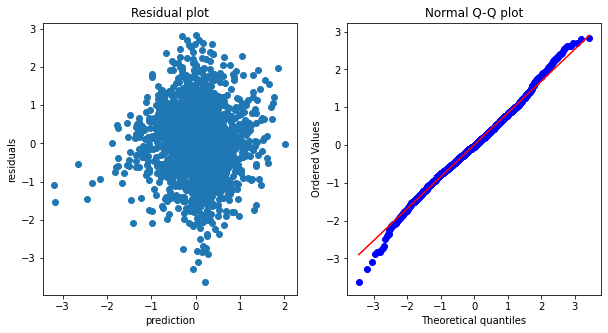

In [11]:
# Do simple linear regression

lm_fitted = rg.doSimpleLinearRegression(X, y)
y_pred = lm_fitted.predict(X)
rg.printMetricResults(y, y_pred, pt_boxcox)
residuals = y_pred - y

# print('Simple regression coef: \n')
# print(*list(zip(input_features, lm_fitted.coef_)), sep='\n')
    
print('Simple regression coef: ', lm_fitted.coef_, '\n')

pu.makeMainResidualPlot(y_pred, residuals)
# pu.makeFeatureResidualPlots(X, residuals, input_features)

print('\nEvaluations on test data:\n')
y_test_pred = lm_fitted.predict(X_test)
rg.printMetricResults(y_test, y_test_pred, pt_boxcox)


Poly scores:  [0.283, 0.321, 0.339, 0.315, 0.316] 

Poly mean cv r^2: 0.315 +- 0.018 

r2:  0.3744
MAE:  0.5999  -  177.4
MSE:  0.6101  -  178.5
RMSE:  0.7811  -  197.9
Poly coef:  [-1.49168122e-07 -9.50173161e-02  5.45799658e-02 -1.28545855e+00
  1.06689198e-01  6.80106732e-07 -2.74529861e-01 -7.59978024e-02
  8.14993350e-02 -2.66142828e-02  2.15127750e-01  3.38578525e-01
 -8.68904595e-05 -9.07235620e-04 -1.00134500e-03 -1.63910805e-02
  6.48785097e-04  3.12687686e-08 -9.28158709e-04  1.11287403e-03
  8.24171926e-04  1.25538389e-03 -1.89439081e-03  5.37527388e-04
 -3.42380667e-07  7.44167422e-05 -6.13048696e-03  1.35036342e-04
  7.97445577e-08 -1.24647138e-05 -2.67522249e-04  4.72111368e-04
 -2.74324125e-04 -2.23455903e-04 -7.56627135e-04 -6.01282372e-07
  5.05946459e-03  1.13277344e-03 -2.19876680e-07  1.20492584e-02
 -4.49404857e-03  7.05130249e-03  4.03164560e-03 -2.78212857e-04
 -1.64628872e-03 -3.85137439e-06 -2.94467188e-04 -7.98347332e-08
 -7.55534187e-04 -5.78904420e-04  5.945

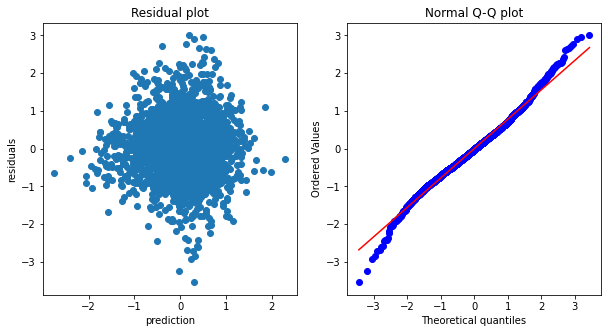

In [12]:
# Do linear regression with polynomial features

lm_poly_fitted, poly = rg.doPolynomialRegression(X, y)
X_poly = poly.transform(X)
y_pred = lm_poly_fitted.predict(X_poly)
rg.printMetricResults(y, y_pred, pt_boxcox)
residuals = y_pred - y

# print('Poly coef: \n')
# print(*list(zip(poly.get_feature_names(input_features), lm_poly_fitted.coef_)), sep='\n')
    
print('Poly coef: ', lm_poly_fitted.coef_, '\n')

pu.makeMainResidualPlot(y_pred, residuals)
# pu.makeFeatureResidualPlots(X_poly, residuals, input_features)

print('\nEvaluations on test data:\n')
y_test_pred = lm_poly_fitted.predict(poly.transform(X_test))
rg.printMetricResults(y_test, y_test_pred, pt_boxcox)



r2:  0.2692
MAE:  0.653  -  183.3
MSE:  0.7126  -  190.0
RMSE:  0.8442  -  205.4
LassoCV simple alpha:  0.0014057540825200062 

LassoCV simple coef:  [ 0.07440498 -0.04709499 -0.22774237 -0.32716886 -0.32204014  0.00180676
 -0.19321846  0.01920628  0.08356521 -0.05739252  0.04470051  0.1618257 ] 


Evaluations on test data:

r2:  0.2337
MAE:  0.6972  -  188.2
MSE:  0.8047  -  200.7
RMSE:  0.897  -  211.8


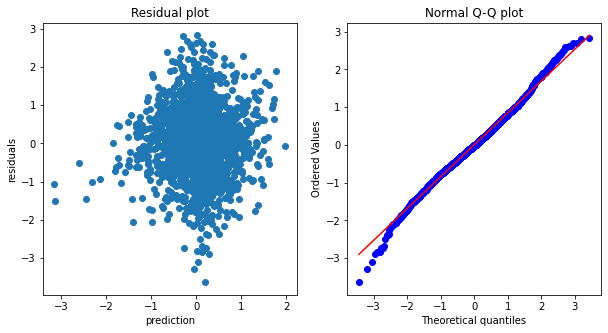

In [13]:
# Do LassoCV regression 

lasso_model_fitted, std = rg.doLassoCV(X,y)
X_std = std.transform(X)
y_pred = lasso_model_fitted.predict(X_std)
rg.printMetricResults(y, y_pred, pt_boxcox)
residuals = y_pred - y

print('LassoCV simple alpha: ', lasso_model_fitted.alpha_, '\n')
print('LassoCV simple coef: ', lasso_model_fitted.coef_, '\n')

pu.makeMainResidualPlot(y_pred, residuals)
# pu.makeFeatureResidualPlots(X_std, residuals, input_features)

print('\nEvaluations on test data:\n')
y_test_pred = lasso_model_fitted.predict(std.transform(X_test))
rg.printMetricResults(y_test, y_test_pred, pt_boxcox)

/Users/NickPC/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.840405711054245, tolerance: 2.3306444872256544
  model = cd_fast.enet_coordinate_descent(


r2:  0.364
MAE:  0.6052  -  178.0
MSE:  0.6202  -  179.6
RMSE:  0.7876  -  198.6
LassoCV poly alpha:  0.0004380803764332246 

LassoCV poly coef:  [ 0.          0.          0.         -0.          0.0488612  -0.
 -0.00572578  0.         -0.          0.          0.10757055  0.47876174
  0.         -0.07870904 -0.28126554 -0.25556437  0.30223805 -0.08642164
 -0.5147027   0.6288655   0.04221985  0.         -0.20101555 -0.06831062
  0.10475715  0.         -0.19282461  0.05422385  0.10998472  0.36739677
  0.33757406  0.01917946 -0.         -0.02674034 -0.14154927 -0.36373374
  0.02254795  0.08770748 -0.12616184  0.06292666 -0.          0.09013342
 -0.         -0.         -0.08120239 -0.14114755 -0.66289804 -0.52694266
 -0.08013044 -0.         -0.19936962  0.17596471 -0.          0.24421372
  0.17621214 -0.26781699 -0.         -1.09658304  1.08616075 -0.10221942
  1.05144922 -0.01681297 -0.          0.03486213 -0.         -0.10321566
 -0.13948865  0.32567352  0.          0.78122945 -0.5363125

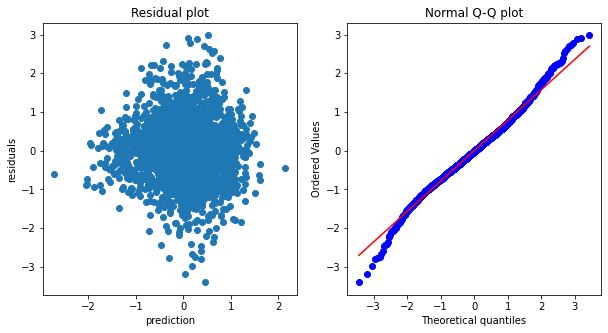

In [14]:
# Do LassoCV regression with poly features

lasso_model_poly_fitted, std, poly = rg.doLassoCV(X,y,True)
X_poly_std = std.transform(poly.transform(X))
y_pred = lasso_model_poly_fitted.predict(X_poly_std)
rg.printMetricResults(y, y_pred, pt_boxcox)
residuals = y_pred - y

print('LassoCV poly alpha: ', lasso_model_poly_fitted.alpha_, '\n')
print('LassoCV poly coef: ', lasso_model_poly_fitted.coef_, '\n')

pu.makeMainResidualPlot(y_pred, residuals)
# pu.makeFeatureResidualPlots(X_poly_std, residuals, input_features)

print('\nEvaluations on test data:\n')
y_test_pred = lasso_model_poly_fitted.predict(std.transform(poly.transform(X_test)))
rg.printMetricResults(y_test, y_test_pred, pt_boxcox)

r2:  0.2694
MAE:  0.6532  -  183.3
MSE:  0.7125  -  190.0
RMSE:  0.8441  -  205.4
RidgeCV simple alpha:  3.0 

RidgeCV simple coef:  [ 0.0765825  -0.05074947 -0.23041454 -0.33541723 -0.32407155  0.00089147
 -0.21035532  0.03579098  0.09172269 -0.06427697  0.04880403  0.1676884 ] 


Evaluations on test data:

r2:  0.2316
MAE:  0.6985  -  188.4
MSE:  0.8068  -  200.9
RMSE:  0.8982  -  212.0


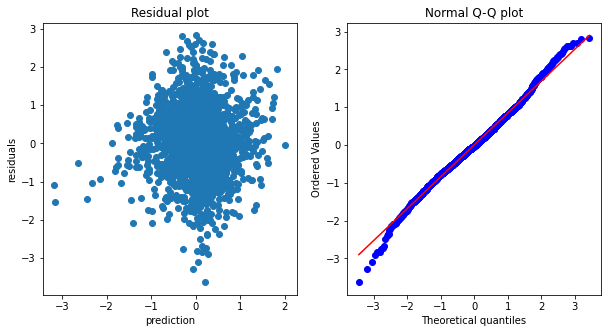

In [15]:
# y_pred = rg.doRidgeCV(X,y)
# rg.printMetricResults(y, y_pred, pt_boxcox)

# Do RidgeCV regression 

ridge_model_fitted, std = rg.doRidgeCV(X,y)
X_std = std.transform(X)
y_pred = ridge_model_fitted.predict(X_std)
rg.printMetricResults(y, y_pred, pt_boxcox)
residuals = y_pred - y

print('RidgeCV simple alpha: ', ridge_model_fitted.alpha_, '\n')
print('RidgeCV simple coef: ', ridge_model_fitted.coef_, '\n')

pu.makeMainResidualPlot(y_pred, residuals)
# pu.makeFeatureResidualPlots(X_std, residuals, input_features)

print('\nEvaluations on test data:\n')
y_test_pred = ridge_model_fitted.predict(std.transform(X_test))
rg.printMetricResults(y_test, y_test_pred, pt_boxcox)


r2:  0.3643
MAE:  0.605  -  178.0
MSE:  0.6199  -  179.6
RMSE:  0.7873  -  198.6
LassoCV poly alpha:  2.757575757575758 

LassoCV poly coef:  [ 0.          0.03939744  0.19195788 -0.2529969   0.28134977 -0.21137006
 -0.23875538  0.09155141 -0.0724563   0.00703185  0.28252457  0.35441346
  0.13823884 -0.10035835 -0.3023127  -0.28471523  0.25256425 -0.10306036
 -0.44783509  0.41010131  0.21819671  0.00931184 -0.20039294 -0.07075145
  0.12845249  0.01261763 -0.19011426  0.08137903  0.137032    0.28618984
  0.25857365  0.09711378 -0.09691099 -0.09048209 -0.1470848  -0.35975682
  0.03692328  0.10289977 -0.10061666  0.33271164 -0.12566161  0.26425596
 -0.03254748 -0.01748601 -0.07198852 -0.19425472 -0.60664353 -0.42169942
 -0.26354095 -0.05423419 -0.28067931  0.22822621 -0.17679047  0.24908625
  0.20719797 -0.21770624 -0.00703616 -0.29474794  0.56293944 -0.24127025
  0.92588878 -0.03069443  0.01052757  0.31083235  0.0473202  -0.12950871
 -0.22094865  0.42626019  0.007009    0.5753552  -0.433

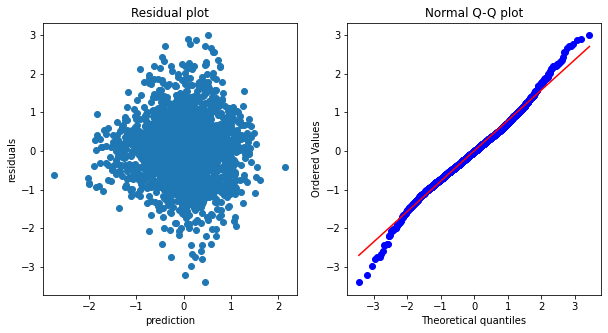

In [16]:
# y_pred = rg.doRidgeCV(X,y,True)
# rg.printMetricResults(y, y_pred, pt_boxcox)

# Do RidgeCV regression with poly features

ridge_model_poly_fitted, std, poly = rg.doRidgeCV(X,y,True)
X_poly_std = std.transform(poly.transform(X))
y_pred = ridge_model_poly_fitted.predict(X_poly_std)
rg.printMetricResults(y, y_pred, pt_boxcox)
residuals = y_pred - y

print('RidgeCV poly alpha: ', ridge_model_poly_fitted.alpha_, '\n')
print('RidgeCV poly coef: ', ridge_model_poly_fitted.coef_, '\n')

pu.makeMainResidualPlot(y_pred, residuals)
# pu.makeFeatureResidualPlots(X_poly_std, residuals, input_features)

print('\nEvaluations on test data:\n')
y_test_pred = ridge_model_poly_fitted.predict(std.transform(poly.transform(X_test)))
rg.printMetricResults(y_test, y_test_pred, pt_boxcox)